# Machine Learning Model Validation Code base

### Developed by : 
- Version v1
- Dated : 10th May 2023
- Last edited by : Kinsuk Ghatak 

### Description :
- This code base serves the basic purpose of providing a guideline and python code references for any ML credit risk model    validation  and needs to be updated/modified as per the user’s requirement.

- The code does not include the sensitivity analysis as on date explicitly as the Grid Search is included
  here. Grid search helps us find the optimal hyperparameter selection.
  
  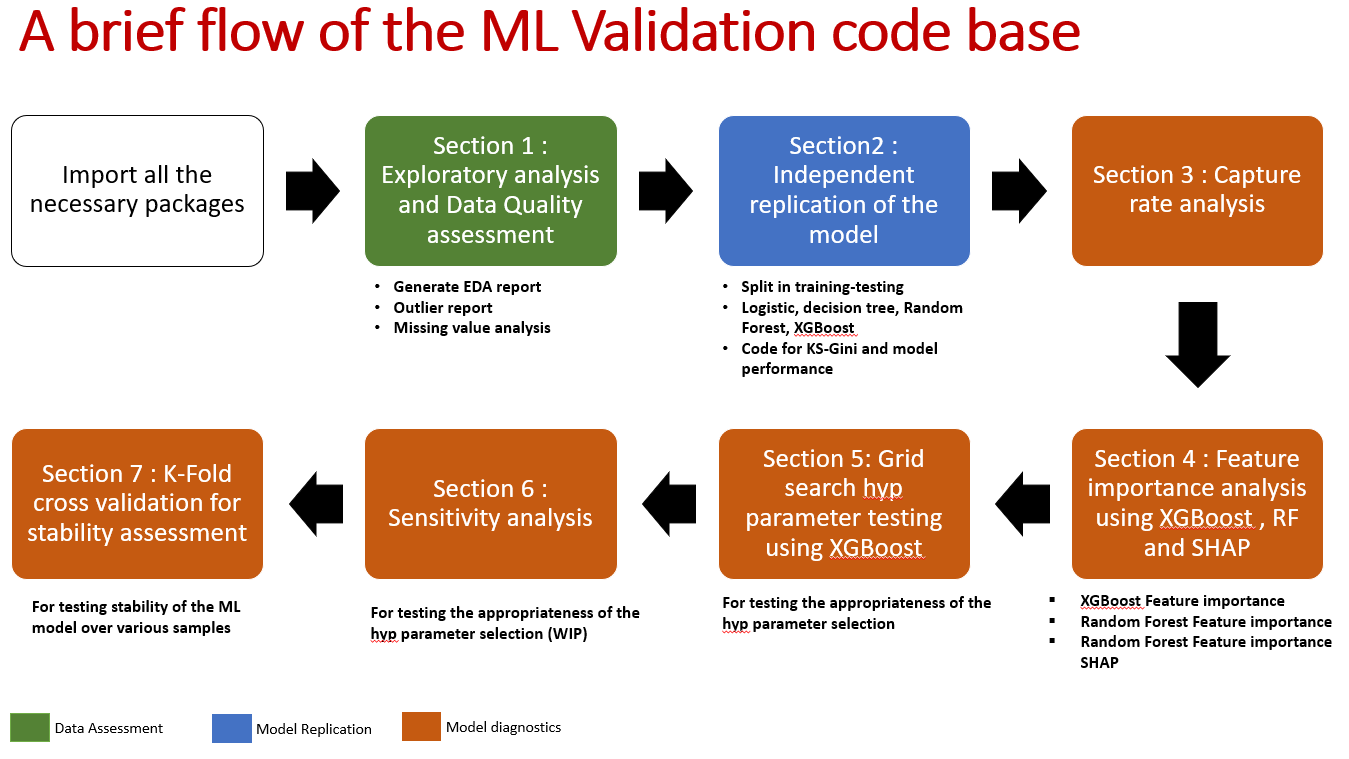

### Importing required packages

In [1]:
#importing python libraries
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import sklearn.metrics as metrics
from sklearn import metrics
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
%matplotlib inline
from sklearn.metrics import r2_score
from scipy import stats
# pd.set_option('display.max_columns', None)
# pd.set_option('display.max_rows', None)
import warnings
warnings.filterwarnings('ignore')#ignores all generated warnings
from sklearn.model_selection import GridSearchCV
import xgboost as xgb
import shap
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score
from numpy import mean
from numpy import std
from sklearn.model_selection import LeaveOneOut

from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score ,recall_score
from sklearn.metrics import roc_auc_score ,roc_curve, auc
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from ipysankeywidget import SankeyWidget

In [2]:
# Change the current working directory
# Import the os module
import os
os.chdir(r'C:\Users\kghatak003\Desktop\Work\ML_Validation_Code_Package')

### Importing Data

In [3]:
sample_data = pd.read_csv(r'C:\Users\kghatak003\Desktop\Work\ML_Validation_Code_Package\sample_data.csv')

In [4]:
df = sample_data.copy()
print("Dimension of the data: ", df.shape)
df.head()

Dimension of the data:  (1000, 21)


,Creditability,Account Balance,Duration of Credit (month),Payment Status of Previous Credit,Purpose,Credit Amount,Value Savings/Stocks,Length of current employment,Instalment per cent,Sex & Marital Status,...,Duration in Current address,Most valuable available asset,Age (years),Concurrent Credits,Type of apartment,No of Credits at this Bank,Occupation,No of dependents,Telephone,Foreign Worker
0,0,1,18,4,2,1049,1,2,4,2,...,4,2,21,3,1,1,3,1,1,1
1,0,1,9,4,0,2799,1,3,2,3,...,2,1,36,3,1,2,3,2,1,1
2,0,2,12,2,9,841,2,4,2,2,...,4,1,23,3,1,1,2,1,1,1
3,0,1,12,4,0,2122,1,3,3,3,...,2,1,39,3,1,2,2,2,1,2
4,0,1,12,4,0,2171,1,3,4,3,...,4,2,38,1,2,2,2,1,1,2


# Section 1:  Exploratory Data Analysis and Data Quality assesment:

### Report generation using Sweetviz: 

In [9]:
#creating a EDA report using sweetviz
import sweetviz as sv
analyze_report = sv.analyze(df)
analyze_report.show_html('sweetviz_EDA.html', open_browser= True) #Change open_browser to TRUE if you intend to display the report in browser 

                                             |                                             | [  0%]   00:00 ->…

Report sweetviz_EDA.html was generated! NOTEBOOK/COLAB USERS: the web browser MAY not pop up, regardless, the report IS saved in your notebook/colab files.


### EDA

### Exploratory analysis of the data and genefrate the whole quality check report of the final data used : 

In [5]:

# Select the final variables for which you wnt to do the data QC analysis 

final_model_features=df.columns[2:].values


def data_qc_analysis (variables,dataframe) :
    df_outlier_count=pd.DataFrame()
    df_summary_outlier_count=pd.DataFrame()


    
    ## Drop the customer id and dependent variable for the data QC analysis : 
#     df_copy=df_copy.drop (['customer_id','default_flag'],inplace=True,axis=1,errors='ignore')

    df_copy=dataframe.drop(['Creditability'],axis=1,errors='ignore')
    
    print("Data QC Analysis report : ")
    print("\n")
    
    ##*******************Data Dimensions summary*****************************************************##
    print("Data Dimension summary:")
    
    n_rows=df_copy.shape[0]
    n_cols=df_copy.shape[1]
    numeric_cols=df_copy.select_dtypes(exclude=['object']).shape[1]
    cols=df_copy.columns
    df_data_dim_Summary=pd.DataFrame([[n_rows,n_cols,numeric_cols]],columns=['# rows','# Columns','# numeric cols'])
    display(df_data_dim_Summary)
    print("\n")
    
    
    ##*************Missing value analysis *********************************************************##
    
    print("Missing value summary:")
    percent_missing=df_copy.isnull().sum()*100/len(df_copy)
    missing_value_df=pd.DataFrame({'Column_Name':df_copy.columns,
                                  'Percent_Missing':percent_missing})
    missing_value_df.sort_values('Percent_Missing',inplace=True,ascending=False)
    print("\n")
    print("Top Missing Values:")
    
    display(missing_value_df.head())
    
    
    ###**Convert variables to numeric formats ***##
    df_copy.iloc[:,:]=df_copy.iloc[:,:].apply(pd.to_numeric)
    
    
    ##******************Summary Statistics analysis **********************************************##
    df_copy_descrb=df_copy[variables].describe([.05,.25,.5,.75,.9,.95,.99])
    print("\n")
    print("Summary statistics:")
    
    display(df_copy_descrb.T)
    
    ##***************************Outlier Analysis ***************************##
    df1=df_copy_descrb[variables].copy()
    
    for column in df1:
        Q1=np.percentile(df1[column],25,interpolation='midpoint')
        Q3=np.percentile(df1[column],75,interpolation='midpoint')
        IQR=Q3-Q1
        upper=Q3+1.5*IQR
        lower=Q1-1.5*IQR
        max_val=max(df1[column])
        min_val=min(df1[column])
        
        
        #Count of obs above upper bound and below lower bound:
        upper_obs=df1[column]>=(Q3+1.5*IQR)
        upper_count=upper_obs.sum()
        
        lower_obs=df1[column]<=(Q1-1.5*IQR)
        lower_count=lower_obs.sum()
        
        total_outlier_count=upper_count+lower_count
        
        df_outlier_count=pd.DataFrame([[column,total_outlier_count,upper_count,lower_count,max_val,min_val]],
                                      columns=['column_name','total_outlier_count','upper_outlier_count',
                                               'lower_outlier_count','max_value','min_value'])
        
        df_summary_outlier_count=df_summary_outlier_count.append(df_outlier_count)
    print("\n")
    print("Outlier analysis summary for the chosen variaables :")
    display(df_summary_outlier_count)

          
    ##***************************Box plots for all the chosen variables for outlier Analysis ***************************##
    
    print("Box plot for the chosen variables:")
    print("\n")
    
    df2=df_copy[variables].select_dtypes(exclude=['object'])
        
    for column in df2:
        plt.figure(figsize=(10,1))
        sns.boxplot(data=df2,x=column)
        
    
    
    
    

Data QC Analysis report : 


Data Dimension summary:


,# rows,# Columns,# numeric cols
0,1000,20,20




Missing value summary:


Top Missing Values:


,Column_Name,Percent_Missing
Account Balance,Account Balance,0.0
Duration of Credit (month),Duration of Credit (month),0.0
Telephone,Telephone,0.0
No of dependents,No of dependents,0.0
Occupation,Occupation,0.0




Summary statistics:


,count,mean,std,min,5%,25%,50%,75%,90%,95%,99%,max
Duration of Credit (month),1000.0,20.903,12.058814,4.0,6.00,12.0,18.0,24.00,36.0,48.0,60.00,72.0
Payment Status of Previous Credit,1000.0,2.545,1.083120,0.0,1.00,2.0,2.0,4.00,4.0,4.0,4.00,4.0
Purpose,1000.0,2.828,2.744439,0.0,0.00,1.0,2.0,3.00,9.0,9.0,10.00,10.0
Credit Amount,1000.0,3271.248,2822.751760,250.0,708.95,1365.5,2319.5,3972.25,7179.4,9162.7,14180.39,18424.0
Value Savings/Stocks,1000.0,2.105,1.580023,1.0,1.00,1.0,1.0,3.00,5.0,5.0,5.00,5.0
Length of current employment,1000.0,3.384,1.208306,1.0,1.00,3.0,3.0,5.00,5.0,5.0,5.00,5.0
Instalment per cent,1000.0,2.973,1.118715,1.0,1.00,2.0,3.0,4.00,4.0,4.0,4.00,4.0
Sex & Marital Status,1000.0,2.682,0.708080,1.0,1.95,2.0,3.0,3.00,3.0,4.0,4.00,4.0
Guarantors,1000.0,1.145,0.477706,1.0,1.00,1.0,1.0,1.00,1.0,3.0,3.00,3.0
Duration in Current address,1000.0,2.845,1.103718,1.0,1.00,2.0,3.0,4.00,4.0,4.0,4.00,4.0




Outlier analysis summary for the chosen variaables :


,column_name,total_outlier_count,upper_outlier_count,lower_outlier_count,max_value,min_value
0,Duration of Credit (month),1,1,0,1000.0,4.000000
0,Payment Status of Previous Credit,1,1,0,1000.0,0.000000
0,Purpose,1,1,0,1000.0,0.000000
0,Credit Amount,0,0,0,18424.0,250.000000
0,Value Savings/Stocks,1,1,0,1000.0,1.000000
0,Length of current employment,1,1,0,1000.0,1.000000
0,Instalment per cent,1,1,0,1000.0,1.000000
0,Sex & Marital Status,1,1,0,1000.0,0.708080
0,Guarantors,1,1,0,1000.0,0.477706
0,Duration in Current address,1,1,0,1000.0,1.000000


Box plot for the chosen variables:




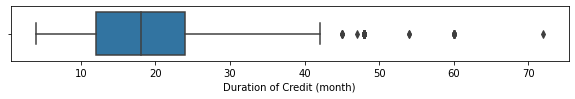

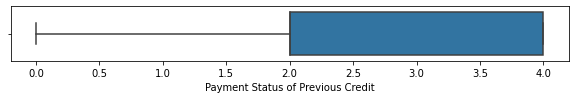

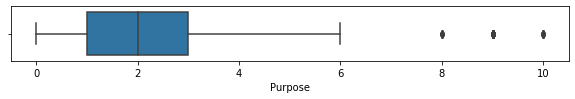

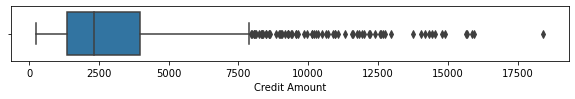

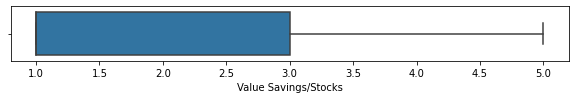

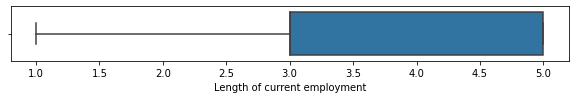

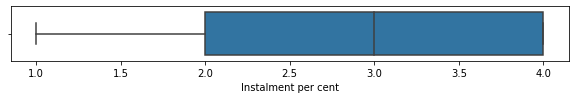

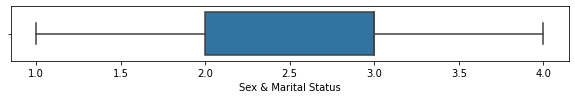

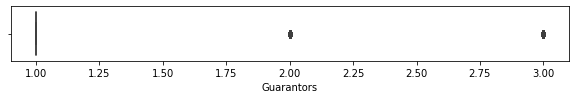

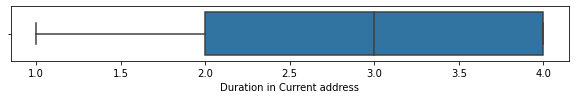

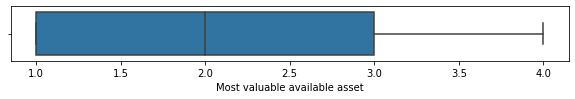

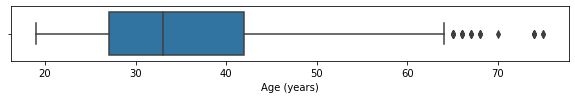

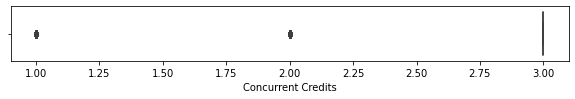

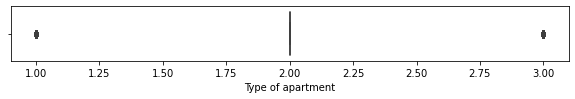

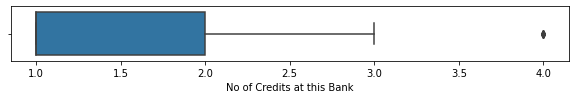

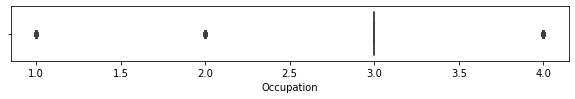

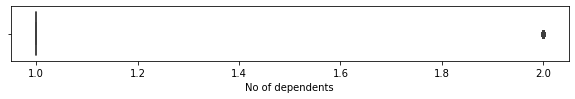

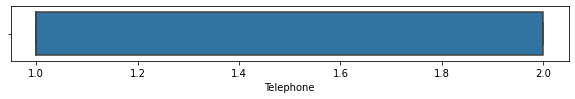

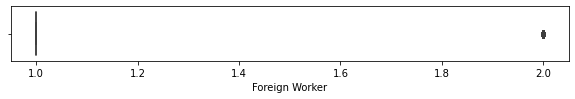

In [6]:
data_qc_analysis(final_model_features,df)



In [99]:

# Select the final variables for which you wnt to do the data QC analysis 

final_model_features=df.columns[2:].values


def data_qc_analysis (variables,dataframe) :
    df_outlier_count=pd.DataFrame()
    df_summary_outlier_count=pd.DataFrame()


    
    ## Drop the customer id and dependent variable for the data QC analysis : 
#     df_copy=df_copy.drop (['customer_id','default_flag'],inplace=True,axis=1,errors='ignore')

    df_copy=dataframe.drop(['Creditability'],axis=1,errors='ignore')
    
    print("Data QC Analysis report : ")
    print("\n")
    
    ##*******************Data Dimensions summary*****************************************************##
    print("Data Dimension summary:")
    
    n_rows=df_copy.shape[0]
    n_cols=df_copy.shape[1]
    numeric_cols=df_copy.select_dtypes(exclude=['object']).shape[1]
    cols=df_copy.columns
    df_data_dim_Summary=pd.DataFrame([[n_rows,n_cols,numeric_cols]],columns=['# rows','# Columns','# numeric cols'])
    display(df_data_dim_Summary)
    print("\n")
    
    
    ##*************Missing value analysis *********************************************************##
    
    print("Missing value summary:")
    percent_missing=df_copy.isnull().sum()*100/len(df_copy)
    missing_value_df=pd.DataFrame({'Column_Name':df_copy.columns,
                                  'Percent_Missing':percent_missing})
    missing_value_df.sort_values('Percent_Missing',inplace=True,ascending=False)
    print("\n")
    print("Top Missing Values:")
    
    display(missing_value_df.head())
    
    
    ###**Convert variables to numeric formats ***##
    df_copy.iloc[:,:]=df_copy.iloc[:,:].apply(pd.to_numeric)
    
    
    ##******************Summary Statistics analysis **********************************************##
    df_copy_descrb=df_copy[variables].describe([.05,.25,.5,.75,.9,.95,.99])
    print("\n")
    print("Summary statistics:")
    
    display(df_copy_descrb.T)
    
    ##***************************Outlier Analysis ***************************##
    df1=df_copy_descrb[variables].copy()
    
    for column in df1:
        Q1=np.percentile(df1[column],25,interpolation='midpoint')
        Q3=np.percentile(df1[column],75,interpolation='midpoint')
        IQR=Q3-Q1
        upper=Q3+1.5*IQR
        lower=Q1-1.5*IQR
        max_val=max(df1[column])
        min_val=min(df1[column])
        
        
        #Count of obs above upper bound and below lower bound:
        upper_obs=df1[column]>=(Q3+1.5*IQR)
        upper_count=upper_obs.sum()
        
        lower_obs=df1[column]<=(Q1-1.5*IQR)
        lower_count=lower_obs.sum()
        
        total_outlier_count=upper_count+lower_count
        
        df_outlier_count=pd.DataFrame([[column,total_outlier_count,upper_count,lower_count,max_val,min_val]],
                                      columns=['column_name','total_outlier_count','upper_outlier_count',
                                               'lower_outlier_count','max_value','min_value'])
        
        df_summary_outlier_count=df_summary_outlier_count.append(df_outlier_count)
    print("\n")
    print("Outlier analysis summary for the chosen variaables :")
    display(df_summary_outlier_count)

          
    ##***************************Box plots for all the chosen variables for outlier Analysis ***************************##
    
    print("Box plot for the chosen variables:")
    print("\n")
    
    df2=df_copy[variables].select_dtypes(exclude=['object'])
        
    for column in df2:
        plt.figure(figsize=(10,1))
        sns.boxplot(data=df2,x=column)
        
    # Save the table and chart to a text file
    with open('output.pdf', 'w') as f:
        f.write('Tables:\n')
        f.write('Data Dimension summary:\n')
        f.write(df_data_dim_Summary.to_string())
        f.write('Missing Value summary:\n')
        f.write(missing_value_df.to_string())
        f.write('Summary statistics:\n')
        f.write(df_copy_descrb.T.to_string())
        f.write('Outlier Analysis summary:\n')
        f.write(df_summary_outlier_count.to_string())

    import matplotlib.backends.backend_pdf
    pdf = matplotlib.backends.backend_pdf.PdfPages("output.pdf")




    N_plots_per_page = 9
    for column in df2:
        plt.figure(figsize=(10,1))
        g = sns.boxplot(data=df2,x=column)
        pdf.savefig(g)
        pdf.close()
    
    
    
    

Data QC Analysis report : 


Data Dimension summary:


,# rows,# Columns,# numeric cols
0,1000,20,20




Missing value summary:


Top Missing Values:


,Column_Name,Percent_Missing
Account Balance,Account Balance,0.0
Duration of Credit (month),Duration of Credit (month),0.0
Telephone,Telephone,0.0
No of dependents,No of dependents,0.0
Occupation,Occupation,0.0




Summary statistics:


,count,mean,std,min,5%,25%,50%,75%,90%,95%,99%,max
Duration of Credit (month),1000.0,20.903,12.058814,4.0,6.00,12.0,18.0,24.00,36.0,48.0,60.00,72.0
Payment Status of Previous Credit,1000.0,2.545,1.083120,0.0,1.00,2.0,2.0,4.00,4.0,4.0,4.00,4.0
Purpose,1000.0,2.828,2.744439,0.0,0.00,1.0,2.0,3.00,9.0,9.0,10.00,10.0
Credit Amount,1000.0,3271.248,2822.751760,250.0,708.95,1365.5,2319.5,3972.25,7179.4,9162.7,14180.39,18424.0
Value Savings/Stocks,1000.0,2.105,1.580023,1.0,1.00,1.0,1.0,3.00,5.0,5.0,5.00,5.0
Length of current employment,1000.0,3.384,1.208306,1.0,1.00,3.0,3.0,5.00,5.0,5.0,5.00,5.0
Instalment per cent,1000.0,2.973,1.118715,1.0,1.00,2.0,3.0,4.00,4.0,4.0,4.00,4.0
Sex & Marital Status,1000.0,2.682,0.708080,1.0,1.95,2.0,3.0,3.00,3.0,4.0,4.00,4.0
Guarantors,1000.0,1.145,0.477706,1.0,1.00,1.0,1.0,1.00,1.0,3.0,3.00,3.0
Duration in Current address,1000.0,2.845,1.103718,1.0,1.00,2.0,3.0,4.00,4.0,4.0,4.00,4.0




Outlier analysis summary for the chosen variaables :


,column_name,total_outlier_count,upper_outlier_count,lower_outlier_count,max_value,min_value
0,Duration of Credit (month),1,1,0,1000.0,4.000000
0,Payment Status of Previous Credit,1,1,0,1000.0,0.000000
0,Purpose,1,1,0,1000.0,0.000000
0,Credit Amount,0,0,0,18424.0,250.000000
0,Value Savings/Stocks,1,1,0,1000.0,1.000000
0,Length of current employment,1,1,0,1000.0,1.000000
0,Instalment per cent,1,1,0,1000.0,1.000000
0,Sex & Marital Status,1,1,0,1000.0,0.708080
0,Guarantors,1,1,0,1000.0,0.477706
0,Duration in Current address,1,1,0,1000.0,1.000000


Box plot for the chosen variables:




ValueError: No figure AxesSubplot(0.125,0.125;0.775x0.755)

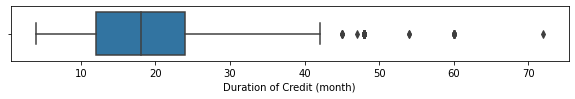

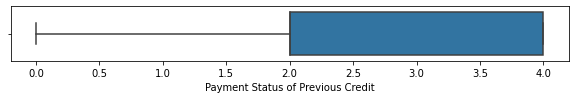

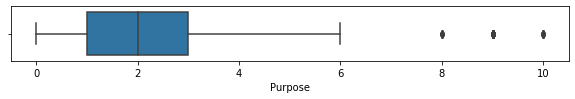

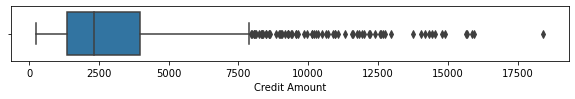

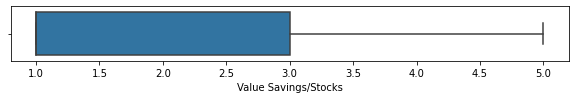

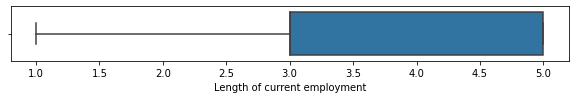

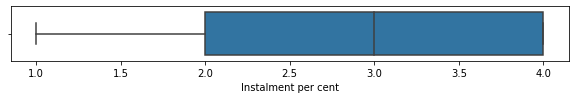

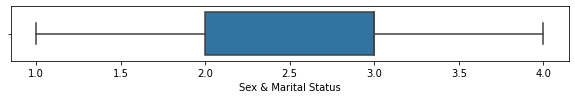

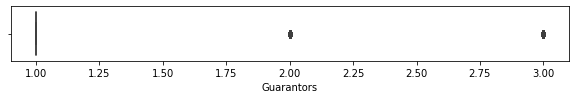

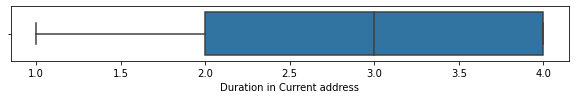

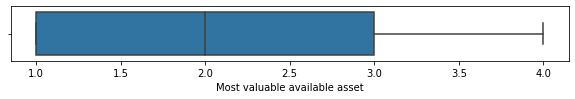

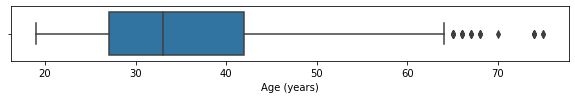

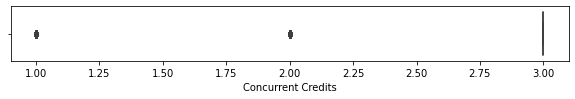

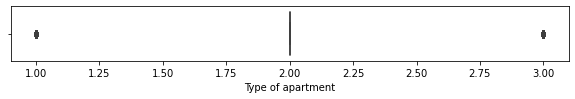

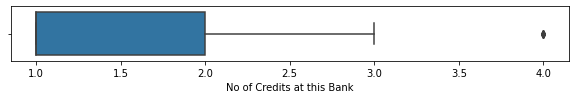

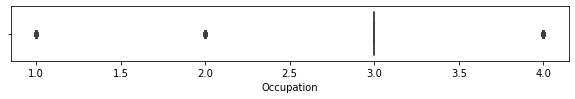

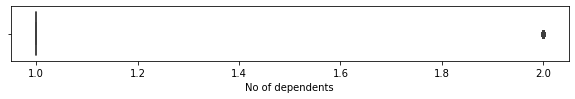

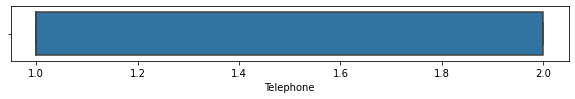

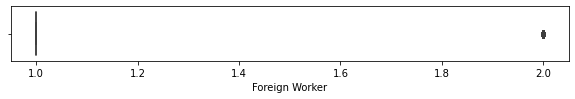

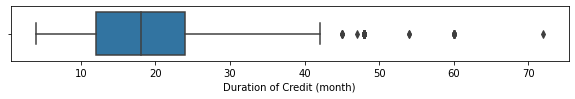

In [100]:
data_qc_analysis(final_model_features,df)

In [94]:
import matplotlib.backends.backend_pdf
pdf = matplotlib.backends.backend_pdf.PdfPages("output.pdf")




N_plots_per_page = 9
for column in df2:
    plt.figure(figsize=(10,1))
    g = sns.boxplot(data=df2,x=column)
    pdf.savefig(g.fig)
pdf.close()

NameError: name 'df2' is not defined

In [10]:
#Identifying columns with null values
df.isnull().sum()

Creditability                        0
Account Balance                      0
Duration of Credit (month)           0
Payment Status of Previous Credit    0
Purpose                              0
Credit Amount                        0
Value Savings/Stocks                 0
Length of current employment         0
Instalment per cent                  0
Sex & Marital Status                 0
Guarantors                           0
Duration in Current address          0
Most valuable available asset        0
Age (years)                          0
Concurrent Credits                   0
Type of apartment                    0
No of Credits at this Bank           0
Occupation                           0
No of dependents                     0
Telephone                            0
Foreign Worker                       0
dtype: int64

### Depending on the presence of null values we may have to employee a missing value imputation technique: 

- First we will only select those observations where we have availability more than 90%
- Once that is done for the remaining columns the missing value would be imputed based on mean/ median etc

In [13]:

##Step 1 : Dropping columns with 90% missing
df = df.loc[:, df.isnull().mean() < .9]

In [23]:
#To count number of duplicate rows
df.duplicated().sum()

0

In [42]:
#Capping and Flooring for individual columns
percentiles = df['Credit Amount'].quantile([0.01, 0.99]).values
df['Credit Amount'] = np.clip(df['Credit Amount'], percentiles[0], percentiles[1])

'''
#Capping and Flooring for group of columns
for col in df_numerical.columns:
    percentiles = df[col].quantile([0.01, 0.99]).values
    df[col] = np.clip(df[col], percentiles[0], percentiles[1])
'''


'\n#Capping and Flooring for group of columns\nfor col in df_numerical.columns:\n    percentiles = df[col].quantile([0.01, 0.99]).values\n    df[col] = np.clip(df[col], percentiles[0], percentiles[1])\n'

In [6]:
## Select and store the final features in a list : 
final_model_features=df.columns[2:].values
final_model_features


array(['Duration of Credit (month)', 'Payment Status of Previous Credit',
       'Purpose', 'Credit Amount', 'Value Savings/Stocks',
       'Length of current employment', 'Instalment per cent',
       'Sex & Marital Status', 'Guarantors',
       'Duration in Current address', 'Most valuable available asset',
       'Age (years)', 'Concurrent Credits', 'Type of apartment',
       'No of Credits at this Bank', 'Occupation', 'No of dependents',
       'Telephone', 'Foreign Worker'], dtype=object)

# Section 2:  Independent replication of the model  


Split the data in 70:30 ratio. Keep 70% for training the model and 30% for testing the model

In [7]:
X = df[final_model_features].copy()
y = df['Creditability'].copy()

 
# split the dataset
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, stratify=y, random_state=101)


In [8]:
## Default rate count: 
print ("Default Rate in training data set : ", y_train.sum()/y_train.count())
print ("Default Rate in testing data set : ", y_test.sum()/y_test.count())

Default Rate in training data set :  0.3
Default Rate in testing data set :  0.3


In [49]:
# print(y_test[y_test['Creditability']==1].count())
# print(y_test[y_test['Creditability']==0].count())

## Build the logistic regression model (Also all other decision tree/ RF models): 

In [11]:
def display_summary(true,pred):
    tn, fp, fn, tp = confusion_matrix(true,pred).ravel()
    print('confusion matrix')
    print(np.array([[tp,fp],[fn,tn]]))
    print('sensitivity is %f',1.*tp/(tp+fn))
    print('specificity is %f',1.*tn/(tn+fp))
    print('accuracy is %f',1.*(tp+tn)/(tp+tn+fp+fn))
    print('balanced accuracy is %',1./2*(1.*tp/(tp+fn)+1.*tn/(tn+fp)))
 

##CHECK CLASS PROPORTIONS IN THE DATA
s=y_train.value_counts()
m1=1- s[1]/(s[0]+s[1])
m2=s[1]/(s[0]+s[1])



## Comment out the model that you want to apply: 
model_tree = LogisticRegression(solver='liblinear',class_weight="balanced",max_iter=20000,C=10000000000,penalty='l2')
# model_tree = LogisticRegression(solver='liblinear',max_iter=2000,class_weight={0:m1,1:m2})
# model_tree = LogisticRegression(solver='liblinear',max_iter=2000,C=1000,penalty='l2')
# model_tree = DecisionTreeClassifier(random_state=42,class_weight="balanced")
# model_tree = RandomForestClassifier(random_state=0,class_weight="balanced",n_estimators=37,bootstrap=True,criterion='gini',max_features='auto')
# model_tree = DecisionTreeClassifier(random_state=0)

# model_tree= GaussianNB()





# model_tree= XGBClassifier(learning_rate =0.5,max_depth = 5,
#                           subsample=0.8,colsample_bytree=0.8,min_child_weight = 1,
#                           objective= 'binary:logistic',alpha=0,scale_pos_weight =2,gamma=0,
#                           max_delta_step =1)

# model_tree= XGBClassifier()

tree = model_tree.fit(X_train[final_model_features],y_train)

ypred_train_dt = model_tree.predict(X_train[final_model_features])
ypred_train_proba=model_tree.predict_proba(X_train[final_model_features])[:,1]

ypred_test_dt = model_tree.predict(X_test[final_model_features])
ypred_test_proba=model_tree.predict_proba(X_test[final_model_features])[:,1]

Accu_Score_training =accuracy_score(y_train,ypred_train_dt)
Accu_Score_testing =accuracy_score(y_test,ypred_test_dt)

rec_score_training=recall_score(y_train,ypred_train_dt)
rec_score_testing=recall_score(y_test,ypred_test_dt)

auc_training = roc_auc_score(y_train,ypred_train_dt)
gini_training = (2*auc_training -1)

auc_testing = roc_auc_score(y_test,ypred_test_dt)
gini_testing = (2*auc_testing -1)



Actual_test_bad_rate=y_test.sum()/y_test.count()
predicted_test_bad_rate =ypred_test_dt.sum()/len(ypred_test_dt)

print("Accuracy_Score_Training : %f"  %Accu_Score_training)
print("Recall_Score_Training : %f"  %rec_score_training)
print("gini_Score_Training : %f"  %gini_training)
print("\t")
print("Accuracy_Score_Testing : %f"  %Accu_Score_testing)
print("Recall_Score_Testing : %f"  %rec_score_testing)
print("gini_Score_Testing : %f"  %gini_testing)


print("\t")


print("Classification  Report : ")
print(classification_report(y_test, ypred_test_dt))
print("\t")
print("Confusion Matrix : ")
print(confusion_matrix(y_test, ypred_test_dt))
display_summary(y_test, ypred_test_dt)




Accuracy_Score_Training : 0.688571
Recall_Score_Training : 0.680952
gini_Score_Training : 0.372789
	
Accuracy_Score_Testing : 0.703333
Recall_Score_Testing : 0.688889
gini_Score_Testing : 0.398413
	
Classification  Report : 
              precision    recall  f1-score   support

           0       0.84      0.71      0.77       210
           1       0.50      0.69      0.58        90

    accuracy                           0.70       300
   macro avg       0.67      0.70      0.68       300
weighted avg       0.74      0.70      0.71       300

	
Confusion Matrix : 
[[149  61]
 [ 28  62]]
confusion matrix
[[ 62  61]
 [ 28 149]]
sensitivity is %f 0.6888888888888889
specificity is %f 0.7095238095238096
accuracy is %f 0.7033333333333334
balanced accuracy is % 0.6992063492063492


In [12]:
## Determine KS-ROC matrix : 

from sklearn.metrics import roc_auc_score
def ks_w2(y_real,y_proba,weight=1):
    df = pd.DataFrame()
    df['real'] = y_real
    df['proba'] = y_proba
    df['weight']=weight

    # Recover each class
    df1 = df[df['real'] == 0]
    df2 = df[df['real'] == 1]

    data1 = df1['proba']
    data2 = df2['proba']

    wt1 = df1['weight']
    wt2 = df2['weight']

    ix1 = np.argsort(data1)
    ix2 = np.argsort(data2)

    data1 = data1.iloc[ix1]
    data2 = data2.iloc[ix2]
    wei1 = wt1.iloc[ix1]
    wei2 = wt2.iloc[ix2]

    data = np.concatenate([data1, data2])
    cwei1 = np.hstack([0, np.cumsum(wei1)/sum(wei1)])
    cwei2 = np.hstack([0, np.cumsum(wei2)/sum(wei2)])
    cdf1we = cwei1[[np.searchsorted(data1, data, side='right')]]
    cdf2we = cwei2[[np.searchsorted(data2, data, side='right')]]

    ks_stat=np.max(np.abs(cdf1we - cdf2we))
    roc_auc = roc_auc_score(df['real'].values,df['proba'].values)

    Gini=2*roc_auc-1
    
    print("KS : ", ks_stat)
    print("Gini : ", Gini)

    return ks_stat,Gini


In [15]:

print("Ks-Gini in development data set:")
ks_w2(y_train,ypred_train_proba)

print("\n")

print("Ks-Gini in validation or testing data set:")
ks_w2(y_test,ypred_test_proba)

Ks-Gini in development data set:
KS :  0.3959183673469388
Gini :  0.5197473275024294


Ks-Gini in validation or testing data set:
KS :  0.42539682539682544
Gini :  0.4951322751322751


(0.42539682539682544, 0.4951322751322751)

## Build XGBoost model with DMatrix Approach: 

In [16]:
## Build XGBoost model with dmatrix approach:
##Set up monotonic constraint if required:
my_tuple=(1)
N=X_train.shape[1]
mono_array=((my_tuple,)*N)

params={
    "objective":"binary:logistic",
    "n_jobs":4,
    "max_depth":3,
    "booster":"gbtree",
    'alpha':0,
    'lambda':0,
    'learning_rate':0.1,
    'eval_metric':'logloss',
    'nthread':2,
    'min_child_weight':1,
    'early_stopping_rounds':5,
#     'monotone_constraints':mono_array
}

from xgboost import train,DMatrix
trainDmatrix=DMatrix(X_train,label=y_train)
testDmatrix=DMatrix(X_test,label=y_test)

booster_model=train(params,trainDmatrix,num_boost_round=120,
                   evals=[(trainDmatrix,'train'),(testDmatrix,'test')],verbose_eval=10)


##Make predictions on train and test data :
import xgboost as xgb

#Convert datasets to special optimised XGBoost oriented dtaa structures:
dtrain=xgb.DMatrix(X_train,label=y_train)
dtest=xgb.DMatrix(X_test,label=y_test)


y_pred_xgb_train_proba=booster_model.predict(dtrain)
y_pred_xgb_test_proba=booster_model.predict(dtest)

[12:29:17] WARNING: C:/buildkite-agent/builds/buildkite-windows-cpu-autoscaling-group-i-0fc7796c793e6356f-1/xgboost/xgboost-ci-windows/src/learner.cc:767: 
Parameters: { "early_stopping_rounds" } are not used.

[0]	train-logloss:0.66558	test-logloss:0.66781
[10]	train-logloss:0.53487	test-logloss:0.56790
[20]	train-logloss:0.48359	test-logloss:0.54367
[30]	train-logloss:0.44865	test-logloss:0.53891
[40]	train-logloss:0.42491	test-logloss:0.53543
[50]	train-logloss:0.39820	test-logloss:0.53399
[60]	train-logloss:0.37974	test-logloss:0.53318
[70]	train-logloss:0.36170	test-logloss:0.53142
[80]	train-logloss:0.34758	test-logloss:0.53452
[90]	train-logloss:0.33490	test-logloss:0.53517
[100]	train-logloss:0.32116	test-logloss:0.53847
[110]	train-logloss:0.31119	test-logloss:0.53929
[119]	train-logloss:0.30140	test-logloss:0.53995


In [17]:
##Determine KS-Gini for the XGBoost approach: 
ks_w2(y_train,y_pred_xgb_train_proba)

KS :  0.7986394557823129
Gini :  0.923265306122449


(0.7986394557823129, 0.923265306122449)

# Section 3 : Capture Rate analysis : 

In [18]:


def cap_rate_analysis(y_act,y_pred_proba):
    
    df_cap_rate=pd.concat([pd.Series(y_act),pd.Series(y_pred_proba)],axis=1)
    df_cap_rate.columns=['y_actual','y_pred_proba']
    df_cap_rate_sorted=df_cap_rate.sort_values(by='y_pred_proba').reset_index(drop=True)

    
    p_10_prob=df_cap_rate_sorted['y_pred_proba'].quantile(0.1)
    p_20_prob=df_cap_rate_sorted['y_pred_proba'].quantile(0.2)
    p_30_prob=df_cap_rate_sorted['y_pred_proba'].quantile(0.3)
    
    df_cap_rate_p10=df_cap_rate_sorted[df_cap_rate_sorted['y_pred_proba']<p_10_prob]
    df_cap_rate_p20=df_cap_rate_sorted[df_cap_rate_sorted['y_pred_proba']<p_20_prob]
    df_cap_rate_p30=df_cap_rate_sorted[df_cap_rate_sorted['y_pred_proba']<p_30_prob]
    
    bads_count_p10=df_cap_rate_p10['y_actual'].sum()
    bads_count_p20=df_cap_rate_p20['y_actual'].sum()
    bads_count_p30=df_cap_rate_p30['y_actual'].sum()
    
    total_bads=df_cap_rate_sorted['y_actual'].sum()
    
    capture_rate_p10=(bads_count_p10/total_bads)*100
    capture_rate_p20=(bads_count_p20/total_bads)*100
    capture_rate_p30=(bads_count_p30/total_bads)*100
    
    capture_rate_df=pd.DataFrame([[capture_rate_p10,capture_rate_p20,capture_rate_p30]])
    capture_rate_df.columns=['Capture_Rate_P10','Capture_Rate_P20','Capture_Rate_P30']
    return(capture_rate_df)



In [19]:
print("Capture rate analysis for the training data using XGBoost model: ")   
display(cap_rate_analysis(y_train,y_pred_xgb_train_proba))
print("\n")
print("Capture rate analysis for the test data using XGBoost model: ")   
display(cap_rate_analysis(y_test,y_pred_xgb_test_proba))

Capture rate analysis for the training data using XGBoost model: 


,Capture_Rate_P10,Capture_Rate_P20,Capture_Rate_P30
0,1.904762,3.333333,3.809524




Capture rate analysis for the test data using XGBoost model: 


,Capture_Rate_P10,Capture_Rate_P20,Capture_Rate_P30
0,1.111111,1.111111,1.111111


# Section 4 : Feature importance analysis using XGBoost and SHAP : 

### Feature importance analysis using XGboost :

Feature Importance using XGBoost


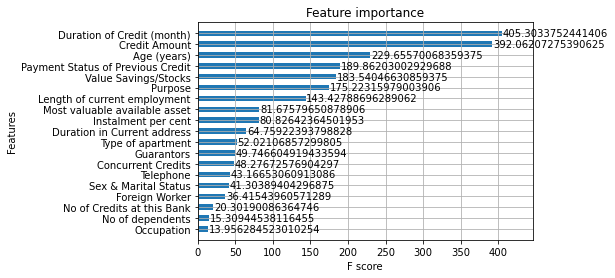

,variable,gains_importance
0,Duration of Credit (month),405.303375
1,Payment Status of Previous Credit,189.862030
2,Purpose,175.223160
3,Credit Amount,392.062073
4,Value Savings/Stocks,183.540466
5,Length of current employment,143.427887
6,Instalment per cent,80.826424
7,Sex & Marital Status,41.303894
8,Guarantors,49.746605
9,Duration in Current address,64.759224


<AxesSubplot:>

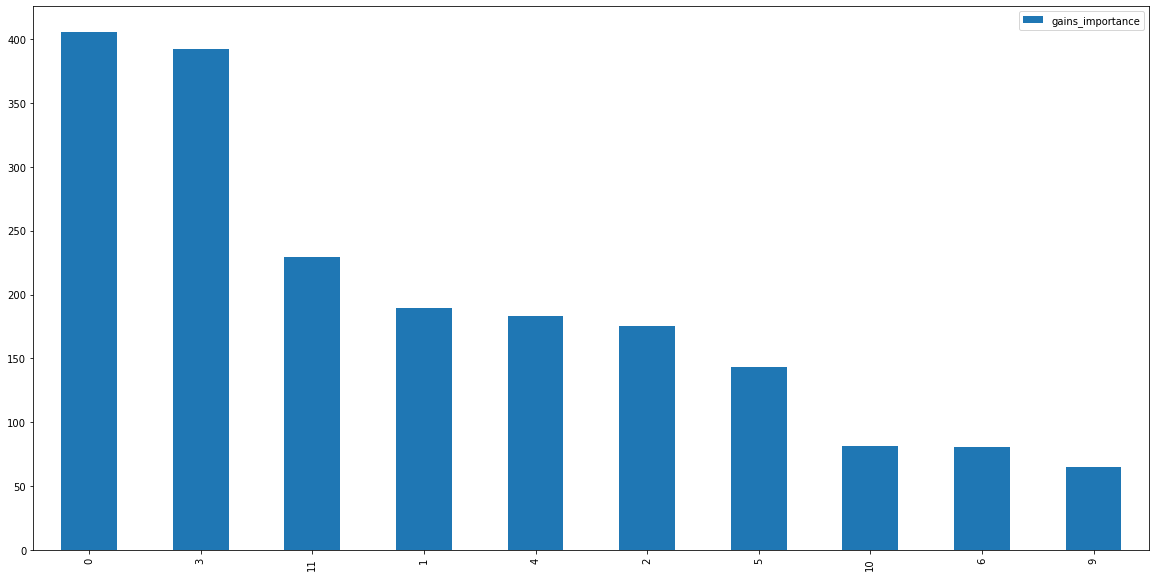

In [20]:
from xgboost import plot_importance

print ("Feature Importance using XGBoost")

#plot feature importance using XGBoost
plot_importance(booster_model,importance_type='total_gain',height=0.5)
plt.show()


## Get all the Gains score in a data frame
gains_score=booster_model.get_score(importance_type='total_gain')
data_xgb_imp=pd.DataFrame(gains_score.items(),columns=['variable','gains_importance']).reset_index(drop=True)
data_xgb_imp.sort_values(by='gains_importance',ascending=False)
display(data_xgb_imp)


## Plot top 10 imp features:
data_xgb_imp.nlargest(10,columns='gains_importance').plot (kind='bar',figsize=(20,10))

### Feature importance analysis using SHAP :

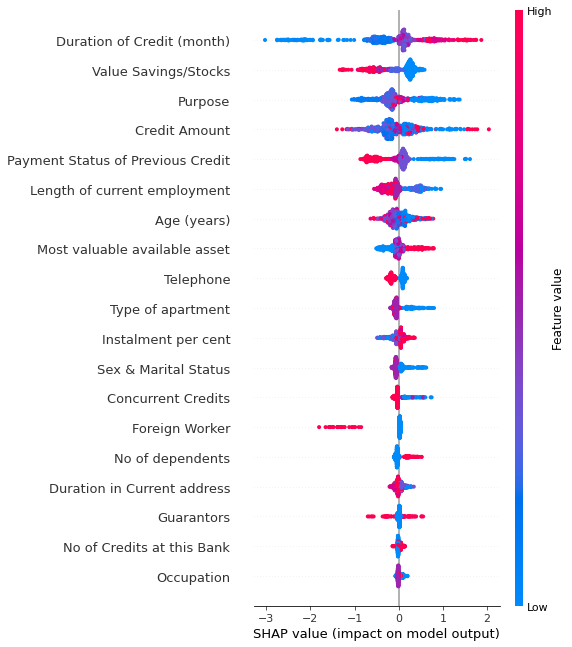

In [35]:
## Model feature evaluation using SHAP:
shap_values = shap.TreeExplainer(booster_model).shap_values(X_train)
shap_interaction_values = shap.TreeExplainer(booster_model).shap_interaction_values(X_train)

shap.summary_plot(shap_values, X_train)

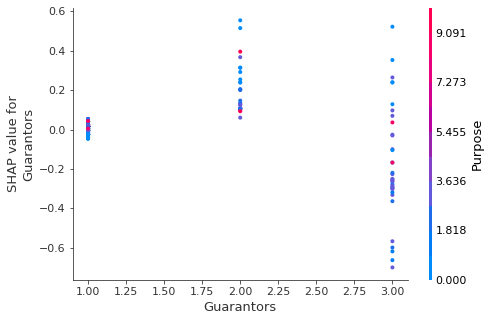

In [36]:
shap.dependence_plot(8, shap_values, X_train)

### Feature importance using Random Forest :

For random forest models, the feature importance can be measured as the average impurity decrease computed from all decision trees in the forest. This is irrespective of the fact whether the data is linear or non-linear (linearly inseparable)

In [21]:
from sklearn.ensemble import RandomForestClassifier
 
forest = RandomForestClassifier(n_estimators=500,
                                random_state=1)
#
# Train the model
#
forest.fit(X_train, y_train.values.ravel())


# Determine feature importance values based on the RF model: 
 
importances = forest.feature_importances_
#
# Sort the feature importance in descending order
#
sorted_indices = np.argsort(importances)[::-1]
 
feat_labels = df.columns[1:]
 
for f in range(X_train.shape[1]):
    print("%2d) %-*s %f" % (f + 1, 30,
                            feat_labels[sorted_indices[f]],
                            importances[sorted_indices[f]]))

 1) Purpose                        0.146223
 2) Account Balance                0.117616
 3) Most valuable available asset  0.116239
 4) Payment Status of Previous Credit 0.074344
 5) Duration of Credit (month)     0.067281
 6) Value Savings/Stocks           0.062235
 7) Credit Amount                  0.055257
 8) Duration in Current address    0.049617
 9) Guarantors                     0.046828
10) Length of current employment   0.044764
11) Instalment per cent            0.042923
12) Concurrent Credits             0.031616
13) No of Credits at this Bank     0.030591
14) Age (years)                    0.028753
15) No of dependents               0.025201
16) Type of apartment              0.023663
17) Sex & Marital Status           0.016564
18) Occupation                     0.014889
19) Telephone                      0.005397


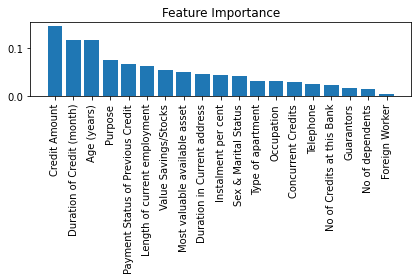

In [25]:
# Visualize the feature importance 


import matplotlib.pyplot as plt
 
plt.title('Feature Importance')
plt.bar(range(X_train.shape[1]), importances[sorted_indices], align='center')
plt.xticks(range(X_train.shape[1]), X_train.columns[sorted_indices], rotation=90)
plt.tight_layout()
plt.show()

## Section 5 : Grid search using XGBoost:

In [18]:
model = xgb.XGBClassifier(seed = 101)

In [19]:
parameters = [{
    'max_depth': range (2, 10, 1),
    'n_estimators': range(0, 240, 40),
    'learning_rate': [0.1, 0.01, 0.05]
}]

grid_search = GridSearchCV(
    estimator=model,
    param_grid=parameters,
    scoring = 'roc_auc',
    n_jobs = 10,
    cv = 10,
    verbose=True
)


In [20]:
grid_search.fit(X_train, y_train)

## Determine and print the best model :
best_model = grid_search.best_estimator_
best_model

Fitting 10 folds for each of 144 candidates, totalling 1440 fits


XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.1, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=2, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              n_estimators=200, n_jobs=None, num_parallel_tree=None,
              predictor=None, random_state=None, ...)

In [21]:
grid_search.score(X_train, y_train)

0.9125898931000971

In [22]:
predicted_y = grid_search.best_estimator_.predict(X_test)
expected_y = y_test

print(metrics.classification_report(expected_y, predicted_y))

              precision    recall  f1-score   support

           0       0.77      0.92      0.84       210
           1       0.65      0.34      0.45        90

    accuracy                           0.75       300
   macro avg       0.71      0.63      0.64       300
weighted avg       0.73      0.75      0.72       300



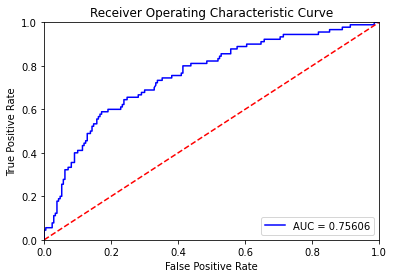

In [23]:
predicted_probas = grid_search.predict_proba(X_test)[::,1]
fpr, tpr, threshold = metrics.roc_curve(y_test, predicted_probas)
roc_auc_xg = metrics.auc(fpr, tpr)
plt.title('Receiver Operating Characteristic Curve')
plt.plot(fpr, tpr, 'b', label = 'AUC = %0.5f' % roc_auc_xg)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

<AxesSubplot:xlabel='Feature'>

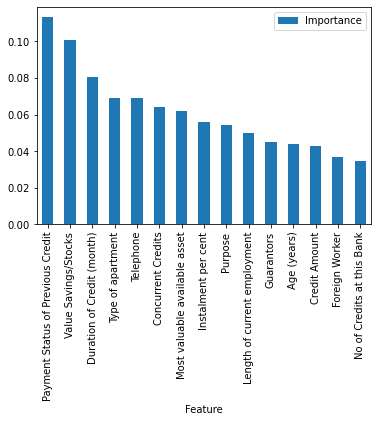

In [24]:
feature_importances = grid_search.best_estimator_.feature_importances_
data = list(zip(X_test.columns, feature_importances))
f_imp = pd.DataFrame(data, columns =['Feature', 'Importance'])

#Selecting a plotting top 15 features with highest Importance
f_imp = f_imp.nlargest(15, ['Importance']) 
f_imp.plot.bar(x = 'Feature')

In [56]:
f_imp

,Feature,Importance
1,Payment Status of Previous Credit,0.113325
4,Value Savings/Stocks,0.100551
0,Duration of Credit (month),0.080651
13,Type of apartment,0.069128
17,Telephone,0.068824
12,Concurrent Credits,0.064254
10,Most valuable available asset,0.061875
6,Instalment per cent,0.055914
2,Purpose,0.054527
5,Length of current employment,0.049657


In [57]:
shap_values = shap.TreeExplainer(best_model).shap_values(X_test)
shap_interaction_values = shap.TreeExplainer(best_model).shap_interaction_values(X_test)

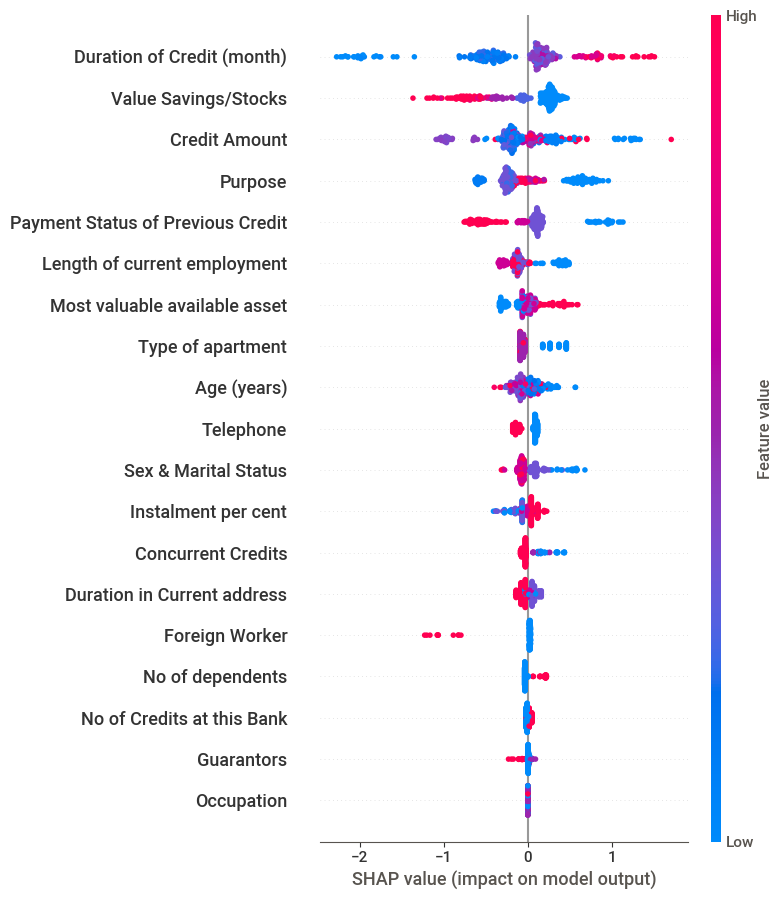

In [58]:
shap.summary_plot(shap_values, X_test)

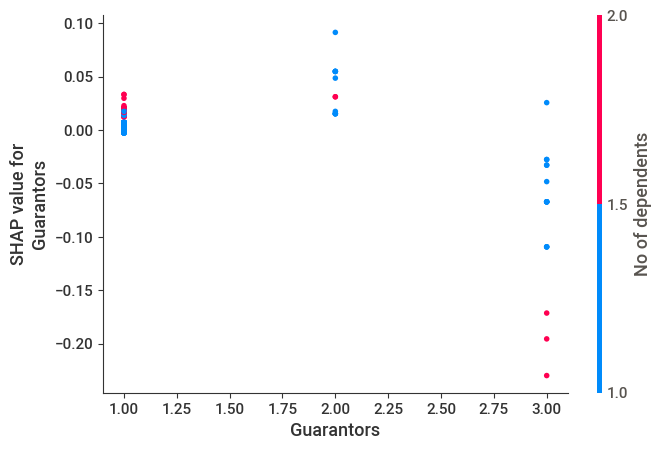

In [59]:
shap.dependence_plot(8, shap_values, X_test)

# Section 6: Sensitivity Analysis

# Section 7: K-fold Cross Validation

In [28]:
from sklearn.metrics import roc_auc_score

def ks_w2_cv(y_real, y_proba, weight=1):
    df = pd.DataFrame()
    df['real'] = y_real
    df['proba'] = y_proba[:,1]
    df['weight']=weight

    # Recover each class,
    df1 = df[df['real'] == 0]
    df2 = df[df['real'] == 1]

    data1 = df1['proba']
    data2 = df2['proba']

    wt1 = df1['weight']
    wt2 = df2['weight']

    ix1 = np.argsort(data1)
    ix2 = np.argsort(data2)

    data1 = data1.iloc[ix1]
    data2 = data2.iloc[ix2]
    wei1 = wt1.iloc[ix1]
    wei2 = wt2.iloc[ix2]

    data = np.concatenate([data1, data2])
    cwei1 = np.hstack([0, np.cumsum(wei1)/sum(wei1)])
    cwei2 = np.hstack([0, np.cumsum(wei2)/sum(wei2)])
    cdf1we = cwei1[[np.searchsorted(data1, data, side='right')]]
    cdf2we = cwei2[[np.searchsorted(data2, data, side='right')]]

    ks_stat=np.max(np.abs(cdf1we - cdf2we))
    roc_auc = roc_auc_score(df['real'],df['proba'],sample_weight=weight)

    Gini=2*roc_auc-1

    print(f"KS: {ks_stat:.4f}")
    print(f"ROC AUC: {roc_auc:.4f}")
    print(f"Gini: {2*roc_auc-1:.4f}")

    return ks_stat,Gini


In [39]:
import warnings
warnings.filterwarnings('ignore')
from xgboost import XGBClassifier
import pandas as pd
from sklearn.metrics import accuracy_score
## Setting up monotonic constraints : ,
my_tuple_1 = (1)
N_col=X_train.shape[1]
N_row=X_train.shape[0]
mono_array = ((my_tuple_1,) * N_col)
train_weights = pd.DataFrame((my_tuple_1,) * N_row)
# Import Required Modules.,
from statistics import mean, stdev
from sklearn.model_selection import StratifiedKFold

# Create StratifiedKFold object
skf = StratifiedKFold(n_splits=10, shuffle=True, random_state=1)
lst_accu_stratified = []
df_summary=pd.DataFrame()
df_summary_final=pd.DataFrame()
for i,(train_index, test_index) in enumerate(skf.split(X_train, y_train,train_weights)):
    x_train_fold, x_test_fold = X_train.iloc[train_index], X_train.iloc[test_index]
    y_train_fold, y_test_fold = y_train.iloc[train_index], y_train.iloc[test_index]
    
    samp_wt_train_fold=train_weights.iloc[train_index]
    samp_wt_test_fold=train_weights.iloc[test_index]

    params_kfold ={
           'objective':'binary:logistic',
            'n_jobs':4,
            'max_depth':3,
            'booster': 'gbtree',
            'alpha': 0,
            'lambda':0,
            'learning_rate': 0.1,
            'eval_metric':'logloss',
            'nthread':2,
            'min_child_weight':1,
#                 'monotone_constraints':mono_array
        }  
    # instantiate the classifier ,
    xgb_clf_kfold = XGBClassifier(**params_kfold)
    xgb_clf_kfold.fit(x_train_fold, y_train_fold)

    y_train_fold_proba=xgb_clf_kfold.predict_proba(x_train_fold)
    y_test_fold_proba=xgb_clf_kfold.predict_proba(x_test_fold)

    y_pred_train_fold = xgb_clf_kfold.predict(x_train_fold)
    y_pred_test_fold = xgb_clf_kfold.predict(x_test_fold)

    acc_score_train_fold=accuracy_score(y_train_fold, y_pred_train_fold)
    acc_score_test_fold=accuracy_score(y_test_fold, y_pred_test_fold)

    train_fold_ks=ks_w2_cv(y_train_fold, y_train_fold_proba,samp_wt_train_fold.values)[0]
    train_fold_gini=ks_w2_cv(y_train_fold,y_train_fold_proba,samp_wt_train_fold.values)[1]

    test_fold_ks=ks_w2_cv(y_test_fold,y_test_fold_proba,samp_wt_test_fold.values)[0]
    test_fold_gini=ks_w2_cv(y_test_fold,y_test_fold_proba,samp_wt_test_fold.values)[1]



    ##Capture rate analysis :

    y_test_proba=pd.Series(y_test_fold_proba[:,1])        

    df_cap_rate=pd.concat([pd.Series(y_test_fold.values),pd.Series(y_test_proba.values)],axis=1)
    df_cap_rate.columns=['y_test_fold','y_test_proba']
    df_cap_rate_sorted=df_cap_rate.sort_values(by='y_test_proba')

    p_10_prob=df_cap_rate_sorted['y_test_proba'].quantile(0.1)
    p_20_prob=df_cap_rate_sorted['y_test_proba'].quantile(0.2)
    p_30_prob=df_cap_rate_sorted['y_test_proba'].quantile(0.3)

    df_cap_rate_p10=df_cap_rate_sorted[df_cap_rate_sorted['y_test_proba']<p_10_prob]
    df_cap_rate_p20=df_cap_rate_sorted[df_cap_rate_sorted['y_test_proba']<p_20_prob]
    df_cap_rate_p30=df_cap_rate_sorted[df_cap_rate_sorted['y_test_proba']<p_30_prob]

    bads_count_p10=df_cap_rate_p10['y_test_fold'].sum()
    bads_count_p20=df_cap_rate_p20['y_test_fold'].sum()
    bads_count_p30=df_cap_rate_p30['y_test_fold'].sum()

    total_bads=df_cap_rate_sorted['y_test_fold'].sum()

    capture_rate_p10=(bads_count_p10/total_bads)*100
    capture_rate_p20=(bads_count_p20/total_bads)*100
    capture_rate_p30=(bads_count_p30/total_bads)*100


    ## Finally,  bringing it all under a summary table : ,
    df_summary=pd.DataFrame([[i,acc_score_train_fold,acc_score_test_fold,train_fold_ks,train_fold_gini,test_fold_ks,test_fold_gini,capture_rate_p10,capture_rate_p20,capture_rate_p30,]],columns=['iteration','acc_score_train','acc_score_test','ks_train_fold','gini_train_fold','ks_test_fold','gini_test_fold','capture_rate_p10','capture_rate_p20','capture_rate_p30'])
    df_summary_final=df_summary_final.append(df_summary)


KS: 0.7952
ROC AUC: 0.9596
Gini: 0.9192
KS: 0.7952
ROC AUC: 0.9596
Gini: 0.9192
KS: 0.5782
ROC AUC: 0.8105
Gini: 0.6210
KS: 0.5782
ROC AUC: 0.8105
Gini: 0.6210
KS: 0.7959
ROC AUC: 0.9590
Gini: 0.9179
KS: 0.7959
ROC AUC: 0.9590
Gini: 0.9179
KS: 0.4354
ROC AUC: 0.7570
Gini: 0.5141
KS: 0.4354
ROC AUC: 0.7570
Gini: 0.5141
KS: 0.7914
ROC AUC: 0.9605
Gini: 0.9210
KS: 0.7914
ROC AUC: 0.9605
Gini: 0.9210
KS: 0.3946
ROC AUC: 0.7094
Gini: 0.4189
KS: 0.3946
ROC AUC: 0.7094
Gini: 0.4189
KS: 0.8042
ROC AUC: 0.9633
Gini: 0.9267
KS: 0.8042
ROC AUC: 0.9633
Gini: 0.9267
KS: 0.3810
ROC AUC: 0.6803
Gini: 0.3605
KS: 0.3810
ROC AUC: 0.6803
Gini: 0.3605
KS: 0.8050
ROC AUC: 0.9602
Gini: 0.9204
KS: 0.8050
ROC AUC: 0.9602
Gini: 0.9204
KS: 0.3673
ROC AUC: 0.6871
Gini: 0.3741
KS: 0.3673
ROC AUC: 0.6871
Gini: 0.3741
KS: 0.7876
ROC AUC: 0.9591
Gini: 0.9182
KS: 0.7876
ROC AUC: 0.9591
Gini: 0.9182
KS: 0.4082
ROC AUC: 0.6803
Gini: 0.3605
KS: 0.4082
ROC AUC: 0.6803
Gini: 0.3605
KS: 0.7937
ROC AUC: 0.9633
Gini: 0.9266


In [40]:
df_summary_final

,iteration,acc_score_train,acc_score_test,ks_train_fold,gini_train_fold,ks_test_fold,gini_test_fold,capture_rate_p10,capture_rate_p20,capture_rate_p30
0,0,0.896825,0.728571,0.795163,0.919207,0.578231,0.620991,0.000000,4.761905,4.761905
0,1,0.879365,0.742857,0.795918,0.917935,0.435374,0.514091,0.000000,4.761905,14.285714
0,2,0.903175,0.728571,0.791383,0.921007,0.394558,0.418853,0.000000,9.523810,9.523810
0,3,0.904762,0.685714,0.804233,0.926682,0.380952,0.360544,14.285714,19.047619,19.047619
0,4,0.900000,0.657143,0.804989,0.920407,0.367347,0.374150,0.000000,4.761905,14.285714
0,5,0.890476,0.685714,0.787604,0.918211,0.408163,0.360544,0.000000,19.047619,23.809524
0,6,0.903175,0.728571,0.793651,0.926598,0.523810,0.510204,4.761905,9.523810,14.285714
0,7,0.896825,0.742857,0.783825,0.916172,0.435374,0.442177,4.761905,9.523810,14.285714
0,8,0.888889,0.771429,0.780801,0.908769,0.646259,0.704568,0.000000,4.761905,4.761905
0,9,0.882540,0.628571,0.780801,0.912512,0.421769,0.413022,0.000000,9.523810,9.523810
